# Basics of aperture photometry

We will see here the basic steps to:
<ol>
    <li><a href="#sec_read">open and display</a> a <a href="https://fits.gsfc.nasa.gov/fits_documentation.html">FITS</a> image,</li>
    <li><a href="#sec_src">detect</a> sources in an image,</li>
    <li><a href="#sec_aper">measure their flux</a> by simple aperture photometry,</li>
    <li><a href="#sec_cal">calibrate these fluxes</a> as catalog magnitude,</li>
    <li><a href="#sec_sso">use this calibration</a> to retrieve the catalog magnitude of our targets, illustrated here by asteroids.</li>
</ol>

<a id='sec_read'></a>
# 1. Reading a FITS image

First, let's read a <a href="https://fits.gsfc.nasa.gov/fits_documentation.html">FITS</a> image taken at the telescope (<a href="https://www.oca.eu/fr/c2pu-accueil">C2PU</a>)

In [1]:
from astropy.io import fits, ascii

filename = './data/0303561001_L.FTZ'
hdu = fits.open(filename)
type(hdu)

astropy.io.fits.hdu.hdulist.HDUList

A <a href="https://fits.gsfc.nasa.gov/fits_documentation.html">FITS</a> file contains the <kbd>data</kbd> itself, and a <kbd>header</kbd> with all the meta-data (describing how, when the image was taken, <em>etc</em>). Together refered as Header Data Unit (HDU).
<strong>NB</strong>: <a href="https://fits.gsfc.nasa.gov/fits_documentation.html">FITS</a> headers are a simple list of strings, in the format<br>
KEYWORD = VALUE / COMMENT<br>
<br>
We can see here that <kbd>fits.open</kbd> return a HDUList (a list of HDUs) objects. The list has in the present case only <strong>one</strong> element, but some instruments may produce <a href="https://fits.gsfc.nasa.gov/fits_documentation.html">FITS</a> with multiple extensions that can be accessed using different indices. Let's place the first element of <kbd>hdu</kbd> in itself for commodity, and see its header:

In [2]:
print('Number of elements in hdu:', len(hdu))
hdu = hdu[0]
hdu.header

Number of elements in hdu: 2


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  384 / length of data axis 1                          
NAXIS2  =                  400 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
XPROC0  = 'omatt set=product/P0303561001OMS007IMAGE_0000.FIT sourcelistset=pro&'
CONTINUE  'duct/P0303561001OMS007SWSRLI0000.FIT ppsoswset=product/P0303561001O&'
CONTINUE  'MS007SIMAGE0000.FIT usecat=yes rotateimage=yes tolerance=1.5 catfil&'
CONTINUE  'e=product/P0303561001OBX000REFCAT0000.FIT maxradecerr=1 maxrmsres=1&'
CONTINUE  '.5 # (omatt-2.57.1) [xmmsas_20190401_1820-18.0.0]'                   
XPROC1  = 'omatt set=product/P0303561001OMS007IMAGE_0000.FIT sourcelistset=pro&'
CONTINUE  'duct/P0303561001O

As you can see, a header may be lengthy, but it carries the ancillary information we need to process the data. It is easy to retrieve the values stored in a header:

In [3]:
epoch = hdu.header.get('DATE-OBS')
filter_name = hdu.header.get('FILTER')
naxis1 = hdu.header.get('NAXIS1')
naxis2 = hdu.header.get('NAXIS2')

print(f'Image {naxis1}x{naxis2} taken on {epoch}, with the {filter_name} filter.')

Image 384x400 taken on 2005-06-22T08:49:07.000, with the UVW1 filter.


Let's plot the image. For that we will first estimate its background level to use a convenient color scale. We use here a <a href="https://www.gnu.org/software/gnuastro/manual/html_node/Sigma-clipping.html">sigma clipping</a> method to reject outliers. We will also amplify a small region to see details.

In [4]:
from astropy.nddata import Cutout2D

# Definition of cutout
position = (160,200)
size = (100, 100)

# Cutout
cutout = Cutout2D(hdu.data, position=position, size=size)
zoom_hdu = hdu.copy()
zoom_hdu.data = cutout.data

C:\Users\Pau\anaconda3\lib\site-packages\matplotlib\image.py:482: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


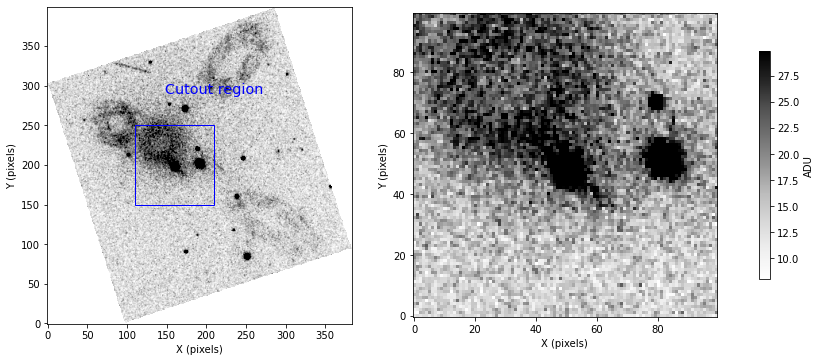

In [5]:
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt

# Compute background statistics
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(hdu.data, sigma=3.0)

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(15,7))

# Plot image
im = ax[0].imshow(hdu.data, cmap='Greys', origin='lower',
          vmin=bkg_median-2*bkg_sigma, 
          vmax=bkg_median+5*bkg_sigma )
ax[0].set_xlabel('X (pixels)')
ax[0].set_ylabel('Y (pixels)')

# Indicate cutout location
rect = plt.Rectangle( [position[0]-size[0]/2., position[1]-size[1]/2.], size[0], size[1], edgecolor='b', facecolor='None' )
ax[0].add_patch(rect)
ax[0].text( position[0]+size[0]/2., position[1]+size[1]/2.+40, 'Cutout region', color='b',fontsize='x-large', ha='center')

# Plot cutout
im = ax[1].imshow(zoom_hdu.data, cmap='Greys', origin='lower',
          vmin=bkg_median-2*bkg_sigma, 
          vmax=bkg_median+5*bkg_sigma )
ax[1].set_xlabel('X (pixels)')
ax[1].set_ylabel('Y (pixels)')

# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU' )

The image was plotted in pixel coordinates. Its astrometry (i.e., how to convert from pixel coordinates into sky coordinates) is described in the header. It is refered as the <a href="https://www.atnf.csiro.au/people/mcalabre/WCS/">World Coordinate System (WCS)</a>:

In [6]:
from astropy.wcs import WCS
wcs = WCS(hdu.header)
wcs

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 53543.367442 from DATE-OBS.
Set MJD-END to 53543.412581 from DATE-END'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 192.586912177354  -23.5624386853659  
CRPIX : 164.243072509766  215.497924804688  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000264729431364685  0.000264729431364685  
NAXIS : 384  400

From the <a href="https://www.atnf.csiro.au/people/mcalabre/WCS/">WCS</a>, we can easily display the image with the equatorial coordinates grid:

C:\Users\Pau\anaconda3\lib\site-packages\matplotlib\image.py:482: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min
C:\Users\Pau\anaconda3\lib\site-packages\matplotlib\image.py:482: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


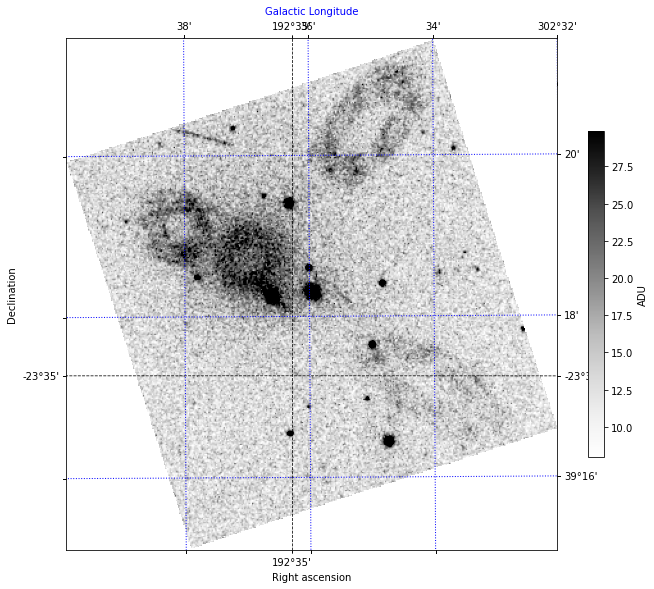

In [7]:
from astropy import units as u

# Define figure & projection
fig = plt.figure(figsize=(11,10))
ax = plt.subplot(projection=wcs,)

# Display image
im = ax.imshow(hdu.data, cmap='Greys', origin='lower', 
               vmin=bkg_median-2*bkg_sigma, 
               vmax=bkg_median+5*bkg_sigma )

# Setup axes
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_axislabel('Right ascension', color='black')
lat.set_axislabel('Declination', color='black')

lon.set_ticks(spacing=5.* u.arcmin)
lat.set_ticks(spacing=5.* u.arcmin)
lon.set_ticklabel_position('bt')
lat.set_ticklabel_position('lr')
lon.set_major_formatter('dd:mm')
lat.set_major_formatter('dd:mm')

ax.grid(color='black', linestyle='dashed', alpha=0.95)

# Add another grid, here the Galactic frame
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='blue', ls='dotted', lw=1)
overlay[0].set_axislabel('Galactic Longitude', color='blue')
overlay[1].set_axislabel(' ')

# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU' )

Now that you are aware of the <a href="https://www.atnf.csiro.au/people/mcalabre/WCS/">WCS</a>, we will extract again the smaller region, to update its associated WCS:

In [8]:
cutout = Cutout2D(hdu.data, position=position, size=size, wcs=wcs)

# Store cutout in HDU and update WCS
zoom_hdu = hdu.copy()
zoom_hdu.data = cutout.data
zoom_hdu.header.update(cutout.wcs.to_header())
zoom_wcs = WCS(zoom_hdu.header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


The code issues a WARNING as python/<a href="https://www.atnf.csiro.au/people/mcalabre/WCS/">WCS</a> implementation does not allow for non-standard <a href="https://www.atnf.csiro.au/people/mcalabre/WCS/">WCS</a> keywords, which are often used to describe plate deformation (i.e., the astrometric solution further than field position and orientation). This is unfortunate for large field of views.

In [9]:
from astropy import units as u

# Define figure & projection
fig = plt.figure(figsize=(11,10))
ax = plt.subplot(projection=wcs,)

# Display image
im = ax.imshow(zoom_hdu.data, cmap='Greys', origin='lower', 
               vmin=bkg_median-2*bkg_sigma, 
               vmax=bkg_median+5*bkg_sigma )

# Setup axes
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_axislabel('Right ascension', color='blue')
lat.set_axislabel('Declination', color='blue')

lon.set_ticks(spacing=5.* u.arcmin)
lat.set_ticks(spacing=5.* u.arcmin)
lon.set_ticklabel_position('bt')
lat.set_ticklabel_position('lr')
lon.set_major_formatter('dd:mm')
lat.set_major_formatter('dd:mm')

ax.grid(color='blue', linestyle='dashed', alpha=0.95)


# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU' )

ValueError: Expected 2 world coordinates, got 0 

<Figure size 792x720 with 2 Axes>

<a id='sec_src'></a>
# 2. Source detection

The <kbd>photutils</kbd> package offers convenient modules for source detection, photometry, <em>etc</em>. We propose a simple didactic work-through here. Please refer to <kbd>photutils</kbd> documentation:
https://photutils.readthedocs.io/en/stable/index.html.<br>

First, we will use the DAOPHOT star finder (<a href="https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract">Stetson,1987</a>). It requires two parameters:
<ul>
    <li><strong>fwhm</strong>: the Full-Width Half-Max of the sources (in pixel). </li>
    <li><strong>threshold</strong>: the minimum value (ADU) above which sources are considered.</li>
</ul>

<figure>
<img src="fig-source_detection.png"><br>
Scheme of source detection by <a href="https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder">DAOStarFinder</a>: only the sources #1 and #3 are detected. The source #2 is below the ADU threshold and the cosmic rays have FWHM too small for detection. 
</figure>

<br>
DAOStarFinder returns an <a href="https://docs.astropy.org/en/stable/table/">astropy Table</a> object. It contains all the detected sources, with their centroid position, geometry, and rough photometry.

In [10]:
from photutils import DAOStarFinder

# Initializing the DAO Star Finder
daofind = DAOStarFinder(fwhm=4., threshold=bkg_median+3.*bkg_sigma)

# Search sources in the frame
sources = daofind(hdu.data)

# Print results
print('Number of sources detected: {:d}'.format(len(sources)))
print('\n')

sources

Number of sources detected: 13




C:\Users\Pau\AppData\Roaming\Python\Python38\site-packages\photutils\detection\daofinder.py:528: RuntimeWarning: invalid value encountered in multiply
  data_sum_1d = np.sum(self.cutout_data * wts, axis=axis + 1)
C:\Users\Pau\AppData\Roaming\Python\Python38\site-packages\photutils\detection\daofinder.py:528: RuntimeWarning: invalid value encountered in multiply
  data_sum_1d = np.sum(self.cutout_data * wts, axis=axis + 1)
C:\Users\Pau\AppData\Roaming\Python\Python38\site-packages\photutils\detection\daofinder.py:457: RuntimeWarning: invalid value encountered in multiply
  cutout_data_masked = self.cutout_data * self.kernel.mask


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float32,float64,int32,float64,float64,float64,float64
1,251.45301453252168,84.81148250975484,0.5316213418844603,-0.20617358,-0.06266068611995536,25,0.0,1376.3299560546875,63.605560302734375,-4.508737706701329
2,174.54374071983267,90.6783114153667,0.5908463276381164,0.23545979,-0.09190448693439712,25,0.0,110.39199829101562,3.9871833324432373,-1.501665512931968
3,234.7157788544179,117.81797475543458,0.6153902002262789,0.026581978,0.06700223177114058,25,0.0,59.30799865722656,2.0010130405426025,-0.7531247973242104
4,238.6172890839402,160.20539896359614,0.5524688339248774,-0.32655847,-0.053162078290938906,25,0.0,232.00599670410156,9.677458763122559,-2.4644033235278613
5,160.15367567349244,198.03121601639063,0.5522308792417961,-0.05638172,-0.014770088543611549,25,0.0,3322.0869140625,153.1269073486328,-5.462628778285026
6,191.14841365720443,201.3719147559241,0.5660853985961873,0.060393732,0.13607594592449687,25,0.0,2248.572021484375,90.63021850585938,-4.8931825676524054
7,246.45785707160337,208.2160551041794,0.4996386886401415,0.24169289,-0.004915729797036222,25,0.0,183.39700317382812,7.9319233894348145,-2.2484462772892924
8,102.06079949025398,212.41865928074486,0.4887164449668097,-0.15421152,-0.008228022317975462,25,0.0,83.08499908447266,3.104731798171997,-1.2300602241600918
9,189.15265561707247,220.1243195678604,0.5914487799303224,0.040313378,0.006036551113320783,25,0.0,214.1479949951172,8.557596206665039,-2.330879475714937


As the image is very large (4k x 4k), let's show the location of the detected sources on the cutout frame only:

In [ ]:
# Selection and edition of the centroids
zoom_sources = sources[ (sources['xcentroid']>(position[0]-size[0]/2)) &
                        (sources['xcentroid']<(position[0]+size[0]/2)) &
                        (sources['ycentroid']>(position[1]-size[1]/2)) &
                        (sources['ycentroid']<(position[1]+size[1]/2)) 
                      ]
zoom_sources['xcentroid'] -= (position[0]-size[0]/2)
zoom_sources['ycentroid'] -= (position[1]-size[1]/2)

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

# Show cutout
im= ax.imshow(zoom_hdu.data, cmap='Greys', origin='lower', 
              vmin=bkg_median-2*bkg_sigma, 
              vmax=bkg_median+5*bkg_sigma)

# Overlap detected sources
ax.scatter(zoom_sources['xcentroid'], zoom_sources['ycentroid'],
            alpha=0.6, color='yellow', label='Detected sources')

# Axes...
ax.set_xlim([0,size[0]])
ax.set_ylim([0,size[1]])
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.legend(loc='lower right')

# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU' )

As visible in the figure above, many sources have been detected, but not all. This is a direct consequence of the choice of parameters in <kbd>DAOStarFinder</kbd>. Try changing <kbd>threshold</kbd> and <kbd>fwhm</kbd> to detect more (or less) sources.

<a id='sec_aper'></a>
# 3. Aperture photometry


We will know measure the flux of each detected source using <em>aperture photometry</em>. It is a conceptually very simple method, consisting in summing the flux of all the pixels within a given radius around the source (called an <em>aperture</em>).

However, the signal of the source adds to other signals on each pixel (e.g., bias, dark current, sky background). These must therefore be subtracted in each pixel. Their sum can be evaluated as the median background of the image (that we computed earlier, <kbd>bkg_median</kbd>), or better, locally, close to each source. This is done with an annulus centered on each source: 

<figure>
  <img src="fig-aperture.png">
</figure>

Here, we will directly perform aperture photometry on the full frame, we highly recommend to read the simple example with a single source at
https://photutils.readthedocs.io/en/stable/aperture.html.

## 3.1. Choice of the aperture

We need first to define the <strong>radius</strong> of the aperture: 1 pixel, 5 pixels, 50 pixels?
We will randomly select a source and fit a Gaussian profile on it to objectively choose the aperture.

In [ ]:
import numpy as np

# Define 1D Gaussian function
def gaus(x,a,x0,sigma):
    return (a/np.sqrt(2*np.pi*sigma*sigma))*np.exp(-(x-x0)**2/(2*sigma**2))

In [ ]:
from scipy.optimize import curve_fit


# Randomly choose a source far enough from edges
src_sel = np.random.randint(0,len(zoom_sources))
src_pos = (zoom_sources[src_sel]['xcentroid'], zoom_sources[src_sel]['ycentroid'])
src_siz = 51
while (src_pos[0]<src_siz) or (src_pos[1]<src_siz) or \
      ((zoom_hdu.data.shape[0]-src_pos[0])<src_siz) or \
      ((zoom_hdu.data.shape[1]-src_pos[1])<src_siz):
    src_sel = np.random.randint(0,len(zoom_sources))
    src_pos = (zoom_sources[src_sel]['xcentroid'], zoom_sources[src_sel]['ycentroid'])


# Cutout
src_cut = Cutout2D(zoom_hdu.data, position=src_pos, size=src_siz)
xc = src_siz/2. 
yc = src_siz/2.


fig, ax = plt.subplots(1,3, figsize=(22,8))

# Zoom cutout
im= ax[0].imshow(zoom_hdu.data, cmap='Greys', origin='lower', 
                vmin=bkg_median-2*bkg_sigma, 
                vmax=bkg_median+5*bkg_sigma)
# Overlap detected sources
ax[0].scatter(zoom_sources['xcentroid'], zoom_sources['ycentroid'], alpha=0.6, color='yellow', label='Detected')
ax[0].scatter(zoom_sources[src_sel]['xcentroid'], zoom_sources[src_sel]['ycentroid'], s=400, facecolor='red', alpha=0.3, label='Selected')
ax[0].axvline(zoom_sources[src_sel]['xcentroid'], color='red', alpha=0.3)
ax[0].axhline(zoom_sources[src_sel]['ycentroid'], color='red', alpha=0.3)
# Axes...
ax[0].set_xlim([0,size[0]])
ax[0].set_ylim([0,size[1]])
ax[0].set_xlabel('X (pixels)')
ax[0].set_ylabel('Y (pixels)')
ax[0].legend(loc='best')
ax[0].set_title('Zoom cutout')


# Selection cutout
ax[1].imshow(src_cut.data, cmap='Greys', origin='lower', 
             vmin=bkg_median-2*bkg_sigma, 
             vmax=bkg_median+5*bkg_sigma)
ax[1].set_xlabel('X (pixels)')
ax[1].set_ylabel('Y (pixels)')
ax[1].set_title('Selected source')

# Source profile
x_arr = np.array([x for x in range(src_siz)])
x_sum = np.sum(src_cut.data,axis=1) 
x_sum = x_sum - np.median(x_sum)

# Adjust profile with Gaussian
param, _ = curve_fit(gaus, x_arr, x_sum, p0=[np.max(src_cut.data),src_siz/2.,5])
fwhm = np.abs(param[2])*2.355
gaus_model = gaus(x_arr,*param)

ax[2].step(x_arr, x_sum, where='mid', label='Data')
ax[2].plot(x_arr, gaus_model, linestyle='--', color='red', label='Fit')

x2 = np.linspace(0,50,num=200)
g2 = gaus(x2,*param)
ax[2].plot(x2, g2, linestyle='-', color='green', label='Fit2')


ax[2].axvline(param[1], linestyle='dotted', color='grey')
ax[2].text(param[1], 0, 'Center', rotation=90, color='grey')
ax[2].plot(param[1] + [-fwhm/2., fwhm/2.], [np.max(gaus_model)/2., np.max(gaus_model)/2.], color='orange', linestyle='--')
ax[2].text(param[1] + fwhm/2., np.max(gaus_model)/2., 'FWHM', color='orange')

ax[2].set_xlabel('X (pixels)')
ax[2].set_ylabel('Counts')
ax[2].legend(loc='upper right')
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
ax[2].set_aspect(asp)
ax[2].set_title('Source profile')

print('Peak  : {:.0f}'.format(param[0]))
print('FWHM  : {:.2f}'.format(fwhm))
print('Center: {:.2f}'.format(param[1]))


# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU' )

You can run the block above to (randomly) change the source. 

We see here that the Full-Width Half Maximum (FWHM) is around 4-5 pixels. Practically, choosing an aperture of 1.5-2 times the FWHM allows to count all the photons from the source, without integrating too many photons from the sky. For the surrounding annulus, a few more pixels are generally used

In [ ]:
aperture_radius = 2.0 * fwhm
annulus_radius= [aperture_radius+2,aperture_radius+5]

## 3.2. Photometry of the sources

We will now define the apertures around each source.

In [ ]:
from photutils import (aperture_photometry,
                       CircularAperture,
                       CircularAnnulus)

# Defining apertures
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=aperture_radius)

It is straightforward to compute the total flux of each aperture. They are stored in an <a href="https://docs.astropy.org/en/stable/table/">astropy Table</a>.

In [ ]:
phot_table = aperture_photometry(hdu.data, apertures)
print('Columns in phot_table: ', phot_table.colnames)

We now need to subtract the sky contribution for each opf these apertures. This will be done fron the annuli around each aperture. We will compute the median level (<strong>not</strong> the mean to avoid any bias due to outliers like stars...) of each annulus (in ADU), and subtract it to the total fluxes measured above.<br>
We will store these median local sky levels and the <strong>total fluxes without sky</strong> in <kbd>phot_table</kbd>. 

In [ ]:
# Define annuli
annulus_aperture = CircularAnnulus(positions, 
                                   r_in=annulus_radius[0],
                                   r_out=annulus_radius[1])
annulus_masks = annulus_aperture.to_mask(method='center')

# For each source, compute the median (through sigma/clipping)
bkg_median_arr = []
for mask in annulus_masks:
    annulus_data = mask.multiply(hdu.data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median_arr.append(median_sigclip)

# Store background stat in phot_table
bkg_median_arr = np.array(bkg_median_arr)
phot_table['annulus_median'] = bkg_median_arr
phot_table['aper_bkg'] = bkg_median_arr * apertures.area
phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum'] - phot_table['aper_bkg']

In [ ]:
phot_table

What is the significance of these fluxes?
We remind here that the signal to noise ratio (SNR) is computed as:

$ SNR = \frac{ f_\star }{ \sqrt{\sum \sigma_i^2 }} $, 
with $f_\star$ the flux of the source, and $\sigma_i$ the noises:
<ul>
    <li>$\sigma_{\star}^2 = f_{\star}$, the photon noise of the source itself, </li>
    <li>$\sigma_{sky}^2 = f_{sky}$, the photon noise of the sky within the aperture, </li>
    <li>$\sigma_{dark}^2 = n . d . t$, the noise linked to the dark current ($n$ pixels, $t$ seconds of integration, and $d$ the dark current in  e<sup>-</sup>/s/pixel), </li>
    <li>$\sigma_{RON}^2 = n . RON$, the read-out noise. </li>
</ul>

Here, $f_{\star}$ is stored in <kbd>phot_table['aper_sum_bkgsub']</kbd> and
$f_{sky}$ in <kbd>phot_table['aper_bkg']</kbd>. The quantities $d$ and $RON$ must be measured on the calibration frames (DARK and BIAS respectively). Here, we will only consider the photon noise of the source and the sky:

In [ ]:
phot_table['noise'] = np.sqrt( phot_table['aper_sum_bkgsub'] +  # photon noise: source
                               phot_table['aper_bkg'] )         # photon noise: sky
phot_table['SNR'] = phot_table['aper_sum_bkgsub'] / phot_table['noise']

print('Updated phot_table: ', phot_table.colnames)
print('\n')
phot_table

At this stage, we have detected the sources in the image and measured their fluxes. Congrats!
<br>
For relative photometry, such as the measurement of an exoplanet transit, it may be enough to save the <kbd>phot_table</kbd> of each image, and study the time variability of the sources.

In [ ]:
name_csv = filename[:-8]+'-phot.csv'
ascii.write(phot_table, name_csv, format='csv', overwrite=True )

However, if absolute magnitudes are required (e.g., to compute colors from different filters, or estimate the real amount of light emitted by the source), an additional step is required.

<a id="sec_cal"></a>
# 4. Photometric calibration 

The <em>instrumental</em> magnitudes derived from the flux measurements are obtained as  
<math>
    m<sub>ins</sub> = -2.5 log10(flux / t<sub>exp</sub>},
</math>
with t<sub>exp</sub> the exposure time.

The <em>calibrated</em> magnitudes are offset from the <em>instrumental</em> magnitudes by a constant, called the <em>Zero Point (ZP)</em>: 
<math>
    m<sub>cal</sub> = m<sub>ins</sub> + ZP
</math>.<br>

<strong>NB</strong>: We provide the two equations above to recall the basics behind what follows. Refer to the lecture for an explanation of these equations and how to obtain them.


To compute the Zero Point, we need here to retrieve a catalog of photometric references to compare with the measured fluxes (or hereafter, magnitude). The choice of the catalog is crucial, as any bias or uncertainty will be carried into our calibration.

Here the image was taken with the <a href="https://www.sdss.org/">SDSS</a> i' filter (see the <a href="https://fits.gsfc.nasa.gov/fits_documentation.html">FITS</a> header). We cannot use <a href="https://www.sdss.org/">SDSS</a> catalog, however, as this region of the sky was not imaged by the <a href="https://www.sdss.org/">SDSS</a>.
Fortunately, the <a href="https://panstarrs.stsci.edu/">Pan-STARRS</a> survey, which covered three-fourth of the sky, uses the same filters as <a href="https://www.sdss.org/">SDSS</a>. We will thus query <a href="https://panstarrs.stsci.edu/">Pan-STARRS</a> latest data release (DR2) from the <a href="https://archive.stsci.edu/">MAST archive</a>.

To save time/space, we only query a limited number of columns, with some selection of data made on the server side:

In [ ]:
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord

field = SkyCoord(wcs.wcs.crval[0], wcs.wcs.crval[1], unit=u.deg)
catalog = Catalogs.query_criteria(coordinates=field.to_string(), radius=0.25,
                                  catalog="PANSTARRS", table="mean", data_release="dr2",
                                  nStackDetections=[("gte", 1)],
                                  iMeanPSFMag=[("lt", 21), ("gt", 1)], 
                                  iMeanPSFMagErr=[("lt", 0.02), ("gt", 0.0)], 
                                  columns=['objName','raMean', 'decMean','nDetections',
                                           'iMeanPSFMag', 'iMeanPSFMagErr' ])

This step can obviously be extremely different depending on the telescope, instrument, filter, and observed region of the sky. Many centers provide catalogs, see the <kbd>astroquery</kbd> package for convenient ways to query them: <a href="https://astroquery.readthedocs.io/en/latest/">https://astroquery.readthedocs.io/en/latest/</a>.  

In [ ]:
print('Number of sources in the catalog: {:d}'.format(len(catalog)))
print('Columns in the catalog: ', catalog.colnames)
print('\n')

catalog

Then, we need to link the sources in the image with the <a href="https://panstarrs.stsci.edu/">Pan-STARRS</a> stars listed in the catalog. We will thus first convert the apertures (listed in pixel coordinates) into sky coordinates, and cross-match then with the catalog we just downloaded.

The variable returned by the cross-match are the indices of the matches in the second catalog, their on-sky angular distance, and their 3D distance (sent here to the <kbd>_</kbd> variable, usually used for trash in python).

In [ ]:
coord_apertures = apertures.to_sky(wcs).positions
coord_catalog = SkyCoord(ra=catalog['raMean']*u.deg,
                         dec=catalog['decMean']*u.deg)

xm_id, xm_ang_distance, _ = coord_apertures.match_to_catalog_sky(coord_catalog, nthneighbor=1)

We will only consider valid the association whose distance is small, typically of the size of the seeing (around one arcsecond).

In [ ]:
# Seeing
hdu.header.get('PIXSCALX') * fwhm

The seeing is here of 2.5", so let's take this as maximal distance.

In [ ]:
max_sep = 2.5 * u.arcsec
sep_constraint = xm_ang_distance < max_sep
coord_matches = coord_apertures[sep_constraint]
catalog_matches = catalog[xm_id[sep_constraint]]
coord_catalog_matches = coord_catalog[xm_id[sep_constraint]]

In [ ]:
# Record the RA/Dec of apertures
phot_table['ra'] = coord_apertures.ra.value
phot_table['dec'] = coord_apertures.dec.value

Let's compare the location of the detected sources and their counterparts in the catalog, first by looking at the distribution of their distances on sky, then by plotting the field.

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

# Histogram of distance between sources (image vs catalog)
sep_range = [0,300]
sep_bins = sep_range[1]
ax.hist(xm_ang_distance.to_value()*3600, range=sep_range, bins=sep_bins, color='tab:blue',
        histtype='step', label='All matches ({:})'.format(len(xm_ang_distance)))
ax.hist(xm_ang_distance[sep_constraint].to_value()*3600, range=sep_range, bins=sep_bins,
        color='orange', alpha=0.6, label='Selected ({:})'.format(len(xm_ang_distance[sep_constraint])))

ax.set_xlabel('Angular separation (")')
ax.set_ylabel('Count')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right')

In [ ]:
from astropy.wcs.utils import skycoord_to_pixel


# Catalog to pixels
catalog_x, catalog_y = skycoord_to_pixel(coord_catalog_matches, wcs=wcs)
zoom_cat_x = catalog_x[ (catalog_x>(position[0]-size[0]/2)) &
                        (catalog_x<(position[0]+size[0]/2)) &
                        (catalog_y>(position[1]-size[1]/2)) &
                        (catalog_y<(position[1]+size[1]/2)) ] - (position[0]-size[0]/2)

zoom_cat_y = catalog_y[ (catalog_x>(position[0]-size[0]/2)) &
                        (catalog_x<(position[0]+size[0]/2)) &
                        (catalog_y>(position[1]-size[1]/2)) &
                        (catalog_y<(position[1]+size[1]/2)) ] - (position[1]-size[1]/2)


# Create figure
fig, ax = plt.subplots(1, 2, figsize=(20,12))

# Plot image
im = ax[0].imshow(hdu.data, cmap='Greys', origin='lower',
                  vmin=bkg_median-2*bkg_sigma, 
                  vmax=bkg_median+5*bkg_sigma )

# Plot Sources
ax[0].scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.6, color='yellow', label='Detected')
ax[0].scatter(catalog_x, catalog_y, alpha=1, edgecolor='red', facecolor='None', label='Catalog')

# Indicate cutout location
rect = plt.Rectangle( [position[0]-size[0]/2., position[1]-size[1]/2.], size[0], size[1], edgecolor='b', facecolor='None' )
ax[0].add_patch(rect)
ax[0].text( position[0]+size[0]/2., position[1]+size[1]/2.+40, 'Cutout region', color='b',fontsize='x-large', ha='center')

ax[0].set_xlabel('X (pixels)')
ax[0].set_ylabel('Y (pixels)')
ax[0].legend(loc='lower right')




# Plot cutout
im = ax[1].imshow(zoom_hdu.data, cmap='Greys', origin='lower',
          vmin=bkg_median-2*bkg_sigma, 
          vmax=bkg_median+5*bkg_sigma )
ax[1].scatter(zoom_sources['xcentroid'], zoom_sources['ycentroid'], alpha=0.6, color='yellow', label='Detected')
ax[1].scatter(zoom_cat_x, zoom_cat_y, alpha=1, edgecolor='red', facecolor='None', s=400, label='Catalog')

ax[1].legend(loc='lower right')
ax[1].set_xlabel('X (pixels)')
ax[1].set_ylabel('Y (pixels)')

# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU' )

<ol>
    <li>Why are the red circles drawing a large circular region?</li>
    <li>Why is this region not filling the entire field of view? How can we change this?</li>
</ol>

Let's now compare the instrumental magnitudes with those from the catalog.

In [ ]:
exptime = hdu.header.get('EXPTIME')
ins_mag = -2.5*np.log10( phot_table[sep_constraint]['aper_sum_bkgsub']/exptime )
cat_mag = catalog['iMeanPSFMag'][xm_id[sep_constraint]]

ins_err = ins_mag - -2.5*np.log10( (phot_table[sep_constraint]['aper_sum_bkgsub']+phot_table[sep_constraint]['noise'])/exptime )
cat_err = catalog['iMeanPSFMagErr'][xm_id[sep_constraint]]

phot_table['ins_mag'] = 0
phot_table['ins_mag'][sep_constraint] = ins_mag

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

# Instrumental vs catalog mag
ax[0].errorbar(ins_mag, cat_mag, xerr=ins_err, yerr=cat_err, marker='.', linestyle='none', label='All sources')
ax[0].set_xlabel('Instrument magnitude')
ax[0].set_ylabel('Catalog magnitude')
ax[0].legend(loc='best')
ax[0].set_aspect('equal')

# Magnitude difference as function of catalog magnitude
ax[1].errorbar(cat_mag, cat_mag-ins_mag, xerr=cat_err, yerr=(cat_err+ins_err), marker='.', linestyle='none', label='All sources')
ax[1].set_xlabel('Catalog magnitude')
ax[1].set_ylabel('Instrument - Catalog magnitude')
ax[1].legend(loc='best')

fig.savefig('phot_cal.png', facecolor='white')

Clearly, there is a linear relation between instrument and catalog magnitude, with a Zero Point around 22.5. This relation occurs between catalog magnitude of about 14 to 17.5. Brighter sources have likely saturated in <a href="https://panstarrs.stsci.edu/">Pan-STARRS</a>, as reported on the DR notes. On the other hand, it seems there are no sources fainter than 18 measured on the image.

We will now fit the linear relation for sources within the selected magnitude range (discarding entries with missing magnitude in both catalogs). We will use a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">simple linear regression</a> first (<kbd>LinearRegression</kbd>), then a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html">more advanced regression, robust to outliers</a> (<kbd>RANSACRegressor</kbd>).

In [ ]:
from sklearn import linear_model

# Selection from magnitude range
mag_min, mag_max = 14, 17.5
cond = (cat_mag>mag_min) & (cat_mag<mag_max) & \
       (~cat_mag.mask) & (~np.isnan(ins_mag))

# Create two mock arrays for linear regression
X = ins_mag[cond].reshape(-1, 1)
y = cat_mag[cond].reshape(-1, 1)


# Simple linear regression
linear = linear_model.LinearRegression()
linear.fit(X, y)


# sigma clipping pour choisir le threshold
from scipy import stats
MAD = stats.median_abs_deviation(X-y)
_, _, sig = sigma_clipped_stats(X-y)

print( MAD, sig)


# RANSAC linear regressions
ransac = linear_model.RANSACRegressor(residual_threshold=3*MAD)
# ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)

# Results
print('Photometric calibration:')
print( f'  Linear Slope: {linear.coef_[0][0]:.3f}')
print( f'  Linear ZP   : {linear.intercept_[0]:.3f}\n')
print( f'  RANSAC Slope: {ransac.estimator_.coef_[0][0]:.3f}')
print( f'  RANSAC ZP   : {ransac.estimator_.intercept_[0]:.3f}')


# Plotting regression
# Outliers and Valid points
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Linear regressions (simple and RANSAC)
line_X = np.arange(X.min(), X.max()+1)[:, np.newaxis]
line_y_simple = linear.predict(line_X)
line_y_ransac = ransac.predict(line_X)

fig, ax = plt.subplots(1,2,figsize=(15,5))

# Plot data
ax[0].scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
ax[0].scatter(X[outlier_mask], y[outlier_mask], color='gray', marker='.', label='Outliers')

# Plot regressions
ax[0].plot(line_X, line_y_simple , color='cornflowerblue',  label='Linear regressor')
ax[0].plot(line_X, line_y_ransac, color='navy', label='RANSAC regressor')

# Axes...
ax[0].legend(loc='lower right')
# ax[0].set_ylim([10,18])
ax[0].set_xlabel('Instrument magnitude')
ax[0].set_ylabel('Catalog magnitude')
ax[0].set_aspect('equal')

_, zp_median, zp_sigma = sigma_clipped_stats(y-X, sigma=3)
ax[1].scatter(y[inlier_mask], y[inlier_mask]-X[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
ax[1].scatter(y[outlier_mask], y[outlier_mask]-X[outlier_mask], color='gray', marker='.', label='Outliers')
ax[1].set_xlabel('Catalog magnitude')

ax[1].axhline(zp_median, label='Median')
ax[1].axhline(zp_median+zp_sigma, linestyle='--', label='Standard deviation')
ax[1].axhline(zp_median-zp_sigma, linestyle='--')
print( f'  sigma  ZP   : {zp_sigma:.3f}')

ax[1].set_ylabel('Instrument - Catalog magnitude')
ax[1].legend(loc='best')

The outliers biased the simple linear regression (the relation between m<sub>inst</sub> and m<sub>cal</sub> has a slope of 1). The RANSAC algorithm provides a more robust fit.

The relation we just derived allows to convert our measurements into catalog magnitude, using the RANSAC module. For that, we only have to remove negative values (that cannot be passed to the log10):



In [ ]:
# Positive values
positive = np.where( phot_table['aper_sum_bkgsub']>0 )

# Compute calibrated mag
phot_table['mag'] = 0.
phot_table['mag'][positive] = ransac.predict( (-2.5*np.log10( phot_table[positive]['aper_sum_bkgsub']/exptime)).data.reshape(-1,1)).flatten()

cond = phot_table['mag']>0
phot_table2 = phot_table[cond]
phot_table

This is, obviously, interesting only for sources not matched by counterparts in the catalog, as we will see below.

<a id="sec_sso"></a>
# 5. Photometry of our target

The steps above have detected the sources in the frame (with the chosen thresholds), and linked some with sources from a photometric catalog. 

These were used to calibrate the photometry. We need to use the photometric calibration to measure the catalog magnitude of our target(s). These can be stars or galaxies, or transients such as GRB optical counterparts, variable stars, or Solar System Objects. Here, let's analyze Solar System Objects (SSOs), as they cannot be present in the <a href="https://panstarrs.stsci.edu/">Pan-STARRS</a> catalog we queried previously.


We query the list of known SSOs. The mechanism is similar to the query for the stellar catalog, but is obviously strongly time-dependent. We will use the <a href="http://vo.imcce.fr/webservices/skybot/">SkyBoT</a> cone-search utility.

In [ ]:
from astroquery.imcce import Skybot
from astropy.time import Time

epoch = Time( hdu.header.get('DATE-OBS'), format='isot')
try:
    ssos = Skybot.cone_search(field, 0.25*u.deg, epoch)
    print('Number of SSOs predicted: {:d}'.format(len(ssos)))
    ssos
except:
    print('No SSO in the current Field of View')

Let's see where are these SSOs.

In [ ]:
from astropy.wcs.utils import skycoord_to_pixel


# Catalog to pixels
catalog_x, catalog_y = skycoord_to_pixel(SkyCoord(ssos['RA'],ssos['DEC']), wcs=wcs)
zoom_cat_x = catalog_x[ (catalog_x>(position[0]-size[0]/2)) &
                        (catalog_x<(position[0]+size[0]/2)) &
                        (catalog_y>(position[1]-size[1]/2)) &
                        (catalog_y<(position[1]+size[1]/2)) ] - (position[0]-size[0]/2)

zoom_cat_y = catalog_y[ (catalog_x>(position[0]-size[0]/2)) &
                        (catalog_x<(position[0]+size[0]/2)) &
                        (catalog_y>(position[1]-size[1]/2)) &
                        (catalog_y<(position[1]+size[1]/2)) ] - (position[1]-size[1]/2)


# Create figure
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# Plot image
bkg_mean, bkg_median, bkg_sigma = sigma_clipped_stats(hdu.data, sigma=3.0)
im = ax[0].imshow(hdu.data, cmap='Greys', origin='lower',
                  vmin=bkg_median-2*bkg_sigma, 
                  vmax=bkg_median+5*bkg_sigma )

# Plot Sources
ax[0].scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.6, color='yellow', label='Detected')
ax[0].scatter(catalog_x, catalog_y, alpha=1, edgecolor='blue', facecolor='None', label='SSOs')

# Indicate cutout location
rect = plt.Rectangle( [position[0]-size[0]/2., position[1]-size[1]/2.], size[0], size[1], edgecolor='b', facecolor='None' )
ax[0].add_patch(rect)
ax[0].text( position[0]+size[0]/2., position[1]+size[1]/2.+40, 'Cutout region', color='b',fontsize='x-large', ha='center')

ax[0].set_xlabel('X (pixels)')
ax[0].set_ylabel('Y (pixels)')
ax[0].legend(loc='lower right')




# Plot cutout
im = ax[1].imshow(zoom_hdu.data, cmap='Greys', origin='lower',
          vmin=bkg_median-2*bkg_sigma, 
          vmax=bkg_median+5*bkg_sigma )
ax[1].scatter(zoom_sources['xcentroid'], zoom_sources['ycentroid'], alpha=0.6, color='yellow', label='Detected')
ax[1].scatter(zoom_cat_x, zoom_cat_y, alpha=1, edgecolor='blue', facecolor='None', s=400, label='SSOs')

ax[1].legend(loc='lower right')
ax[1].set_xlabel('X (pixels)')
ax[1].set_ylabel('Y (pixels)')

# Single color bar
fig.colorbar(im, ax=ax, shrink=0.6, label='ADU' )

We can extract the photometry of all predicted sources, as some may not have been detected with <kbd>DAOStarFinder</kbd>. Last time, the apertures were defined by their pixel coordinates, but we can also define them directly from sky coordinates:

In [ ]:
from photutils import SkyCircularAperture

ssos_positions = SkyCoord(ra=ssos['RA'], dec=ssos['DEC'], unit='deg')
skyapertures_ssos = SkyCircularAperture(ssos_positions, 
                                     apertures.to_sky(wcs=wcs).r)
phot_ssos = aperture_photometry(hdu.data, skyapertures_ssos, wcs=wcs)  

Some <kbd>aperture_sum</kbd> values are NaN, or negative, and the corresponding objects can be discarded.

In [ ]:
ssos = ssos[ ~np.isnan(phot_ssos['aperture_sum']) ]
ssos_positions = ssos_positions[ ~np.isnan(phot_ssos['aperture_sum']) ]
phot_ssos = phot_ssos[ ~np.isnan(phot_ssos['aperture_sum']) ]

In [ ]:
print('Number of SSOs with measured flux: {:d}'.format(len(phot_ssos)))
phot_ssos

We now need to compute the background for each aperture, this is very similar as before, but here again, let's define the annuli directly from the sky positions. We then remove objects with negative flux. Finally we compute their catalog photometry and store it.

In [ ]:
from photutils import SkyCircularAperture, SkyCircularAnnulus

annulus_aperture_ssos = SkyCircularAnnulus(ssos_positions, 
                                           r_in=annulus_aperture.to_sky(wcs=wcs).r_in,
                                           r_out=annulus_aperture.to_sky(wcs=wcs).r_out)
annulus_masks_ssos = annulus_aperture_ssos.to_pixel(wcs=wcs).to_mask(method='center')

bkg_median = []
for mask in annulus_masks_ssos:
    annulus_data_ssos = mask.multiply(hdu.data)
    annulus_data_1d = annulus_data_ssos[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
phot_ssos['annulus_median'] = bkg_median
phot_ssos['aper_bkg'] = bkg_median * apertures.area
phot_ssos['aper_sum_bkgsub'] = phot_ssos['aperture_sum'] - phot_ssos['aper_bkg']

ssos = ssos[ phot_ssos['aper_sum_bkgsub']>0 ]
ssos_positions = ssos_positions[ phot_ssos['aper_sum_bkgsub']>0 ]
phot_ssos = phot_ssos[ phot_ssos['aper_sum_bkgsub']>0 ]

cal_mag = ransac.predict( (-2.5*np.log10( phot_ssos['aper_sum_bkgsub']/exptime)).data.reshape(-1,1))
phot_ssos['mag'] = cal_mag

Let's compare the measure magnitude in <a href="https://www.sdss.org/">SDSS</a> i' filter with the predicted V magnitude. <br>
If you are not familiar with filter troughputs, you can find them on the <a href="http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=voservice">SVO Filter Service</a>:
<a href="http://svo2.cab.inta-csic.es/theory/fps3/index.php?id=SLOAN/SDSS.i&&mode=browse&gname=SLOAN&gname2=SDSS#filter">SDSS i'</a> and
<a href="http://svo2.cab.inta-csic.es/theory/fps3/index.php?id=Generic/Johnson.V&&mode=browse&gname=Generic&gname2=Johnson#filter">Generic V</a>

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.scatter(phot_ssos['mag'], ssos['V'], label='SSOs')
ax1.set_xlabel('Measured catalog magnitude')
ax1.set_ylabel('Expected V-band magnitude')
ax1.grid()
ax1.legend(loc='best')

_,_,_ = ax2.hist( (phot_ssos['mag'].data-ssos['V'].data).flatten(), density=True )
ax2.set_xlabel("Magnitude difference (i'-V)")

i_minus_V_mean = np.mean(phot_ssos['mag'].data-ssos['V'].data) 
i_minus_V_std = np.std(phot_ssos['mag'].data-ssos['V'].data) 
i_minus_V_sun = -0.2636
ax2.errorbar(i_minus_V_mean, 0.1, xerr=i_minus_V_std, color='red', fmt='o', label='Mean, std')
ax2.axvline(i_minus_V_sun, color='gold', label='Sun')
ax2.legend(loc='upper left')

In [ ]:
print("Mean  i'-V: {:.2f}".format(i_minus_V_mean))
print("Solar i'-V: {:.2f}".format(i_minus_V_sun))